In [1]:
import numpy as np 
import pandas as pd
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from PIL import Image
from collections import defaultdict
from tqdm import tqdm
from skimage import io
import scipy.stats

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
pd.set_option("display.max_columns", None)

## Data loading 

In [4]:
## Load NIH data
df = pd.read_csv('/data/Data_Entry_2017.csv')
df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
13364,00003475_000.png,No Finding,0,3475,48,F,PA,2992,2991,0.143,0.143,NaN
13075,00003404_000.png,No Finding,0,3404,31,M,PA,2992,2991,0.143,0.143,NaN
19235,00005090_002.png,Infiltration,2,5090,54,F,AP,2500,2048,0.171,0.171,NaN


## Basic descriptive statistics and data sanity checks

In [5]:
# Generate descriptive statistics for a general idea of data tendency and dispersion
df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


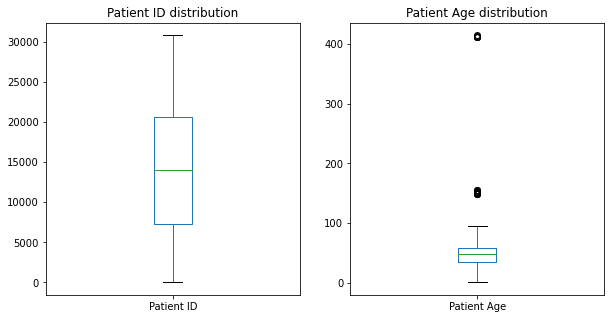

In [6]:
# Check numerical features' distribution and skewness
cols_to_analyze = ['Patient ID','Patient Age']
fig, m_axs = plt.subplots(1,2, figsize = (10, 5))
for column, ax in zip(cols_to_analyze, m_axs.flatten()):
    df[column].plot(kind='box', ax=ax)
    ax.set_title(str(column)+' distribution')

In [7]:
# Drop outliers 
df.drop(df[df['Patient Age'] > 110].index, inplace=True)

In [8]:
# Drop unrelevant columns 
df.drop(labels=["Follow-up #", "Unnamed: 11", "OriginalImage[Width", "Height]", "OriginalImagePixelSpacing[x", "y]"], axis=1, inplace=True)

In [9]:
# Check for any missing values (None, NaN)
df.isnull().any().sum()

0

In [10]:
# One-hot encode gender 
gender = pd.get_dummies(df["Patient Gender"])
df.drop("Patient Gender", axis=1, inplace=True)
df = df.join(gender)

**Insights from basic descriptive statistics and data sanity checks:**
- Outliers present in "Patient Age" column: values higher than 120 y.o. have been dropped
- Unrelevant columns, one of which had missing values: columns have been dropped 
- No missing values in relevant columns
- Important features "Patient Gender" and "Findings" were categorical: features were converted to binary for simplicity in further analysis

## Class distribution analysis
Number of pneumonia vs non-pneumonia cases

In [11]:
# Extract finding labels
finding_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
finding_labels

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype='<U18')

In [12]:
# Create one-hot features for each finding label
for label in finding_labels:
    df[label] = df["Finding Labels"].map(lambda x: 1. if label in x else 0)

In [13]:
df.head()

,Image Index,Finding Labels,Patient ID,Patient Age,View Position,F,M,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,1,58,PA,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,58,PA,0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,1,58,PA,0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,2,81,PA,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,3,81,PA,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


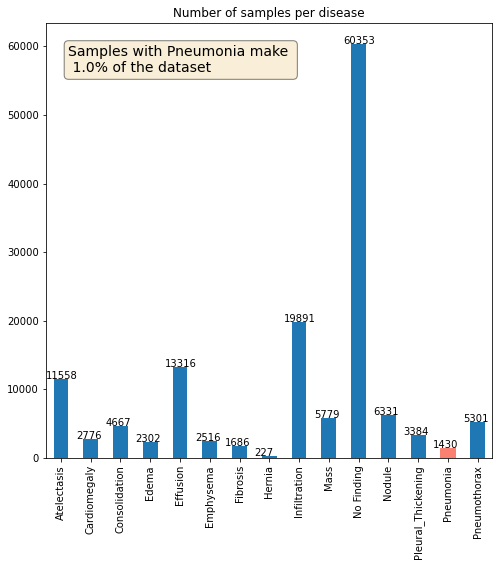

In [14]:
# Number of samples per disease
ax = df[finding_labels].sum().plot(kind='bar', figsize = (8, 8))
ax.set_title('Number of samples per disease')

# Print values above bars
value_counts = [int(x) for x in df[finding_labels].sum().tolist()]
for i, v in enumerate(value_counts):
    ax.text(i-0.5, v+10, str(v))
    
# Highlight info about Pneumonia 
ax.get_children()[13].set_color('salmon')

penumonia_samples_percent = round(df.Pneumonia.sum()/len(df), 2) * 100
text = "Samples with Pneumonia make \n "+ str(penumonia_samples_percent) + "% of the dataset"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

plt.show()

In [15]:
proportion_no_finding = len(df[df["No Finding"] == 1]) / len(df) * 100
print(f'{round(proportion_no_finding)}% of all images in the dataset present no findings')

54% of all images in the dataset present no findings


**Insights from class distribution analysis:** 
- The dataset is highly imbalanced; only 0.01% or all images are pneumonia positive: it will be necessary to use oversampling/undersampling techniques when modelling to balance the training set
- More than half of the dataset represents images with no findings 
- Almost half of the dataset represents non-pneumonia diseases: these images may serve as noise added to training set that could impact positively the training process preventing overfitting 

## Data correlation analysis

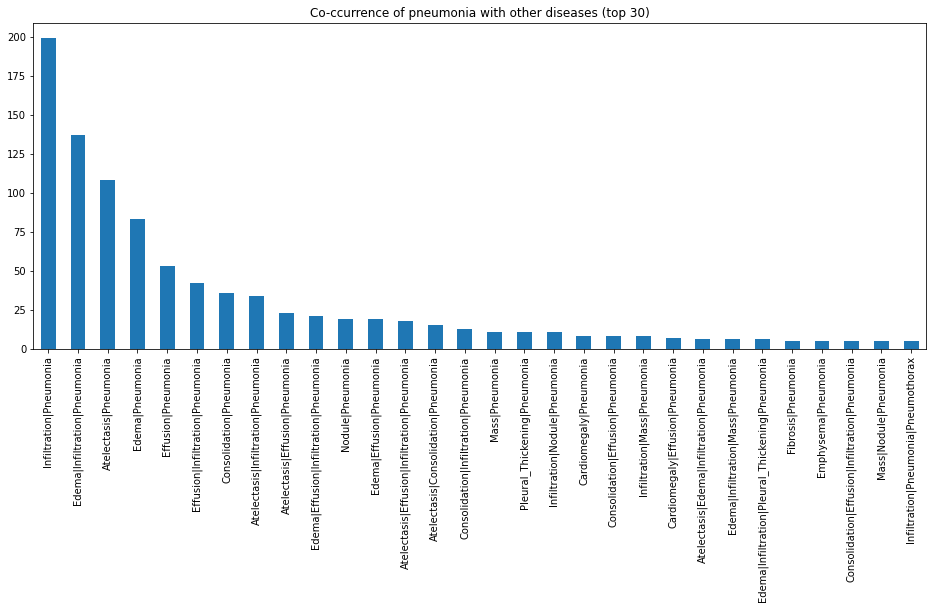

In [16]:
# Co-ccurrence of pneumonia with other diseases
plt.figure(figsize=(16,6))
df[(df.Pneumonia==1) & (df['Finding Labels']!="Pneumonia")]['Finding Labels'].value_counts()[0:30].plot(kind='bar')
plt.title('Co-ccurrence of pneumonia with other diseases (top 30)')
plt.show()

In [17]:
top_comorbid_findings = df[(df.Pneumonia==1) & (df['Finding Labels']!="Pneumonia")]['Finding Labels'].value_counts()[0:5].index
top_comorbid_findings = list(set(chain(*top_comorbid_findings.map(lambda x: x.split('|')).to_list())))
top_comorbid_findings

['Atelectasis', 'Infiltration', 'Effusion', 'Edema', 'Pneumonia']

In [18]:
df.head()

,Image Index,Finding Labels,Patient ID,Patient Age,View Position,F,M,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,1,58,PA,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,58,PA,0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,1,58,PA,0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,2,81,PA,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,3,81,PA,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


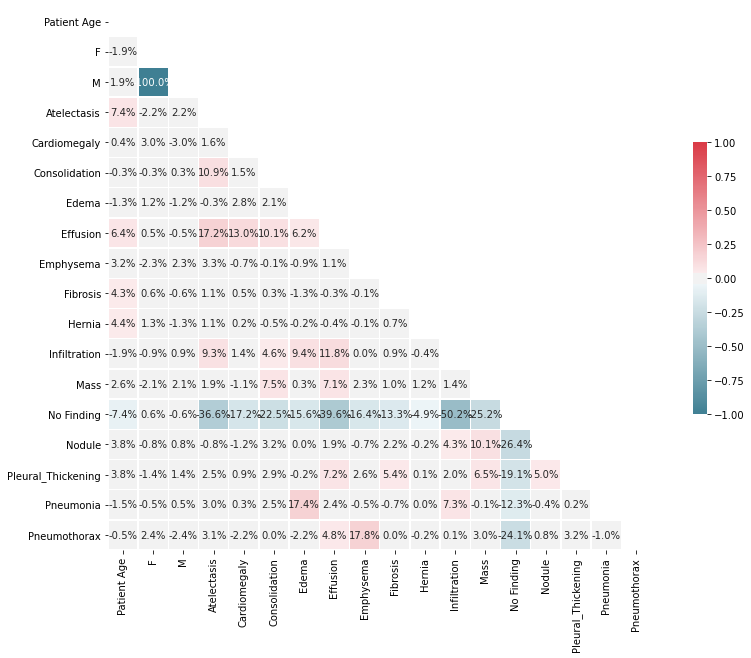

In [19]:
plt.figure(figsize=(15,10))

# Create co
cols = df.iloc[:, [3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]]
corr = cols.corr()

# Mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Generate diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True, fmt=".1%",
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [20]:
# All non-pneumonia diseases
other_diseases = list(finding_labels.copy())
other_diseases.remove('No Finding')
other_diseases.remove("Pneumonia")
other_diseases

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumothorax']

In [21]:
# Create a new column that indicates presence of non-pneumonia disease
df["OtherDisease"] = df[other_diseases].sum(axis=1) >=1

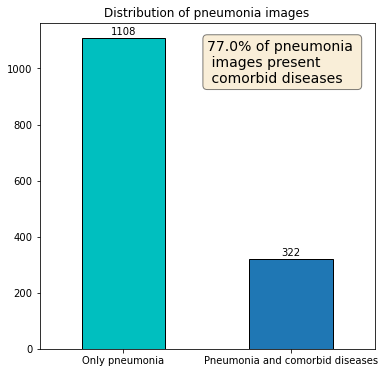

In [22]:
pneumonia_comorbid = df["OtherDisease"][df["Pneumonia"] == 1].value_counts()
ax = pneumonia_comorbid.plot(kind='bar', figsize = (6, 6), edgecolor='black')
ax.set_title('Distribution of pneumonia images')
ax.patches[0].set_facecolor('c')
ax.set_xticklabels(["Only pneumonia", "Pneumonia and comorbid diseases"], rotation=90)

rects = ax.patches
for i, v in enumerate(pneumonia_comorbid):
    height = rects[i].get_height()
    ax.text(rects[i].get_x() + rects[i].get_width() / 2, height + 5, str(v), ha='center', va='bottom')

labels = ax.get_xticklabels()
for label in labels:
    label.set_rotation(0)
    
var = round(pneumonia_comorbid[1] / pneumonia_comorbid.sum() * 100)
text4 = str(var) + "% of pneumonia \n images present \n comorbid diseases"
props4 = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.50, 0.95, text4, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props4)

plt.show()

**Insights from data correlation analysis**:
- Pneumonia is often diagnosed with several other diseases, most common being Infiltration, Edema, Atelectasis, Effusion
- Pneumonia is in some level positively correlated with Edema and Infiltration
- Gender does not seem to be correlated with any of the considered diseases
- 77% of images with pneumonia were diagnosed also with at least one other disease 

# Feature distribution analysis

#### Patient gender distribution

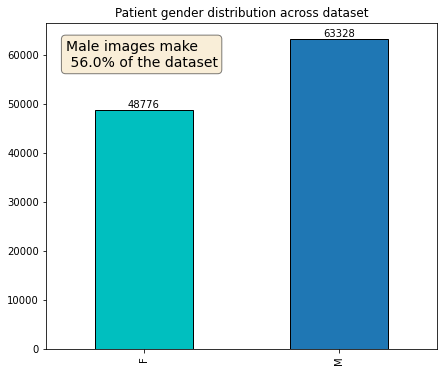

In [23]:
# Patient gender distribution across dataset
plt.figure(figsize = (7, 6))
ax = df["M"].value_counts().sort_values().plot(kind='bar', edgecolor='black')
ax.set_title('Patient gender distribution across dataset')
ax.patches[0].set_facecolor('c')
ax.set_xticklabels(["F", "M"])

rects = ax.patches
for i, v in enumerate(df["M"].value_counts().sort_values()):
    height = rects[i].get_height()
    ax.text(rects[i].get_x() + rects[i].get_width() / 2, height + 5, str(v), ha='center', va='bottom')

men_images_proportion = df["M"].sum() / len(df) * 100
text2 = "Male images make \n "+ str(round(men_images_proportion)) + "% of the dataset"
props2 = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, text2, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props2)

plt.show()

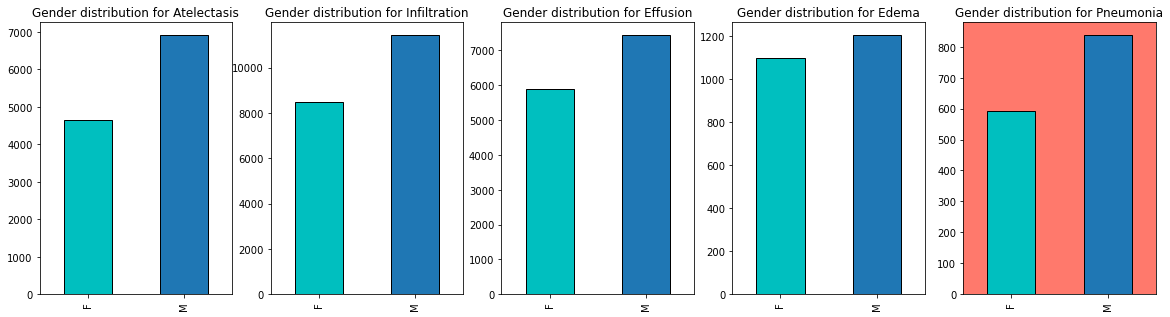

In [24]:
# Patient gender distribution for pneumonia and top comorbid diseases
fig, m_axs = plt.subplots(1, 5, figsize = (20, 5))
for disease, ax in zip(top_comorbid_findings, m_axs.flatten()):
    df["M"][df[disease] == 1].value_counts().sort_values().plot(kind='bar', edgecolor='black', ax=ax)
    ax.patches[0].set_facecolor('c')
    ax.set_title("Gender distribution for " + disease)
    ax.set_xticklabels(["F", "M"])
    
    if disease == "Pneumonia":
        ax.set_facecolor('xkcd:salmon')

#### Patient age distribution

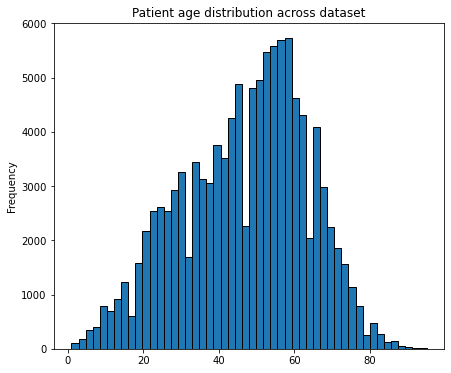

In [25]:
# Patient age distribution across dataset
plt.figure(figsize = (7, 6))
ax = df["Patient Age"].plot(kind='hist', bins=50, edgecolor='black')
ax.set_title('Patient age distribution across dataset')
# TODO proportion of man and woman vs age distribution

plt.show()

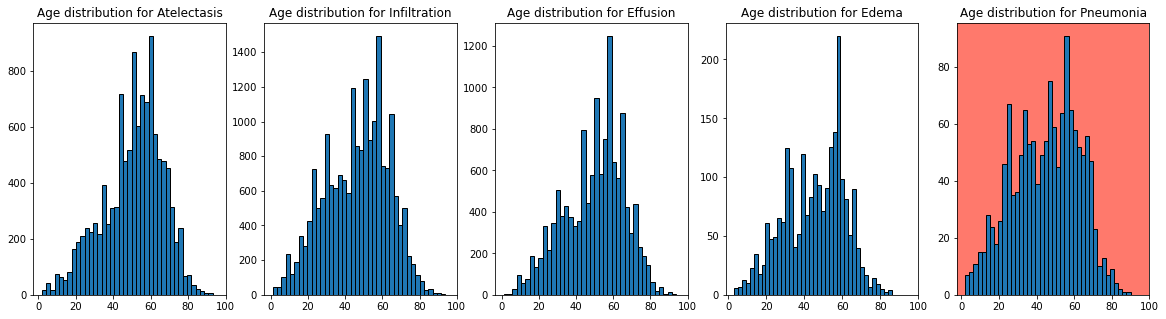

In [26]:
# Patient age distribution for pneumonia and top comorbid diseases
fig, m_axs = plt.subplots(1, 5, figsize = (20, 5))
for disease, ax in zip(top_comorbid_findings, m_axs):
    ax.hist(df["Patient Age"][df[disease] == 1].sort_values(), bins=40, edgecolor='black')
    ax.set_title("Age distribution for "+disease)
    ax.set_xlim(right=100)
    
    if disease == "Pneumonia":
        ax.set_facecolor('xkcd:salmon')
plt.show()

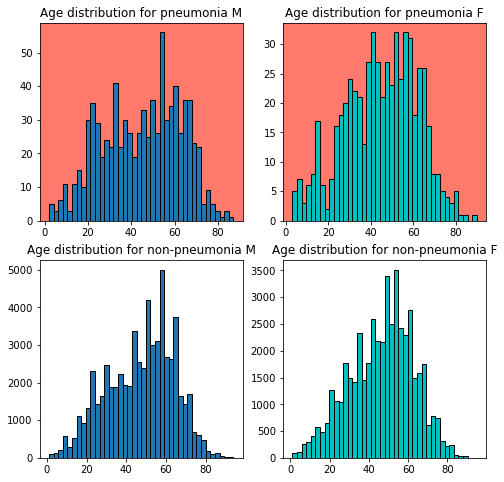

In [27]:
# Age distribution depending on gender for patients diagnosed with pneumonia
fig, m_axs = plt.subplots(2, 2, figsize = (8, 8))

data_to_plot = {
    "pneumonia M": df["Patient Age"][(df["M"] == 1) & (df["Pneumonia"] == 1)],
    "pneumonia F": df["Patient Age"][(df["F"] == 1) & (df["Pneumonia"] == 1)],
    "non-pneumonia M": df["Patient Age"][(df["M"] == 1) & (df["Pneumonia"] == 0)],
    "non-pneumonia F": df["Patient Age"][(df["F"] == 1) & (df["Pneumonia"] == 0)]
}

for ax, key in zip(m_axs.flatten(), data_to_plot.keys()):
    
    if ' F' in key:
        color = 'c'
    else:
        color=None
        
    ax.hist(data_to_plot[key], edgecolor='black', color=color, bins=40)
    ax.set_title("Age distribution for "+ key)
    
    if key.startswith("pneumonia"):
        ax.set_facecolor('xkcd:salmon')
        
    
plt.show()

#### The x-ray view position distribution

In [28]:
df["View Position"].value_counts()

PA    67299
AP    44805
Name: View Position, dtype: int64

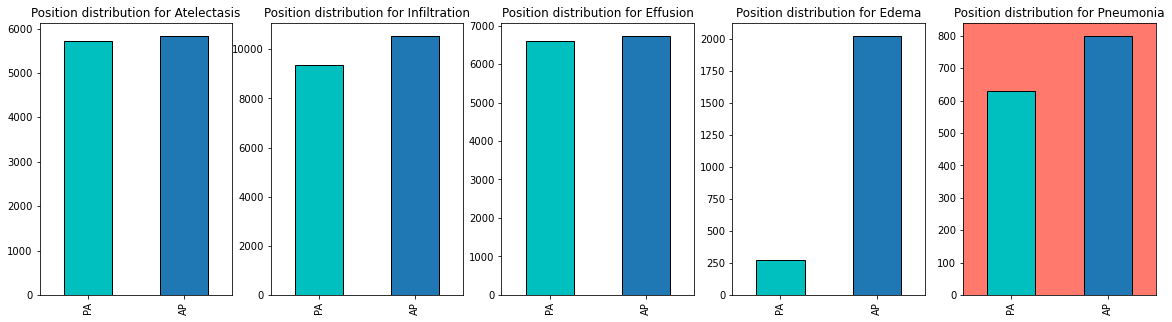

In [29]:
fig, m_axs = plt.subplots(1, 5, figsize = (20, 5))
for disease, ax in zip(top_comorbid_findings, m_axs):
    df["View Position"][df[disease] == 1].value_counts().sort_values().plot(kind='bar', edgecolor='black', ax=ax)
    ax.patches[0].set_facecolor('c')
    ax.set_title("Position distribution for "+disease)
    
    if disease == "Pneumonia":
        ax.set_facecolor('xkcd:salmon')
plt.show()

#### Number of diseases per patient

In [30]:
# Create a new DataFrame with 1 record per patient. Calculate mean age of patients whose record appear more than once;
# calculate "sum" (here a mean) of diseases 
cols = ["Patient ID", "Patient Age", "M", "F", "Pneumonia"] + other_diseases

df2 = df[cols].groupby(["Patient ID"]).mean()

In [31]:
# One-hot encode columns with diseases
df2.iloc[:, 2:] = df2.iloc[:, 2:].applymap(lambda x: 1 if x>0 else 0)

In [32]:
# Calculate sum of diseases for each patient 
df2["Disease_Count"] = df2.iloc[:, 2:].sum(axis=1)

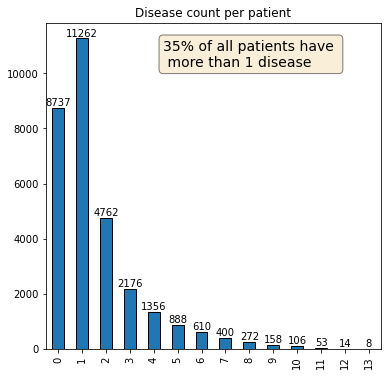

In [33]:
# Plot disease count per patient distribution
ax = df2["Disease_Count"].value_counts().sort_index().plot(kind='bar', figsize = (6, 6), edgecolor='black')
ax.set_title('Disease count per patient')
mean_disease_count = df2["Disease_Count"].mean()

rects = ax.patches
for i, v in enumerate(df2["Disease_Count"].value_counts().sort_index()):
    height = rects[i].get_height()
    ax.text(rects[i].get_x() + rects[i].get_width() / 2, height + 5, str(v), ha='center', va='bottom')

more_than_1_disease = len(df2[df2["Disease_Count"] > 1]) / len(df2) *100
text3 = str(round(more_than_1_disease)) + "% of all patients have \n more than 1 disease"
props3 = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.35, 0.95, text3, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props3)

plt.show()

**Insights from feature distribution analysis:**
- Male images make 56% of the dataset
- Pneumonia and comorbid diseases are more frequent among men, part of which is due to slightly imbalanced dataset: it may be necessary to balance the training set 
- Dataset represents images from patients in all ages; the largest age group represented is between 50-65 years old 
- Age distribution for pneumonia and comorbid diseases is very similar; the vast majority of patients diagnosed in each case are around 60 yeards old
- Gender distribution among images diagnosed with pneumonia and non-pneumonia are similar, always peaking at aroung 60 years old
- Majority of images were taken from a PA (posteroanterior) view, as opposed to AP (anteroposterior); slightly more diagnoses were made on images taken from AP view
- A large group of patients were diagnosed with exactly one disease
- 35% of patients have more than one disease
- There are thousands of patients diagnosed with several diseases

# Glimpse at the X-ray images

In [34]:
image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}
df['ImagePath'] = df['Image Index'].map(image_paths.get)

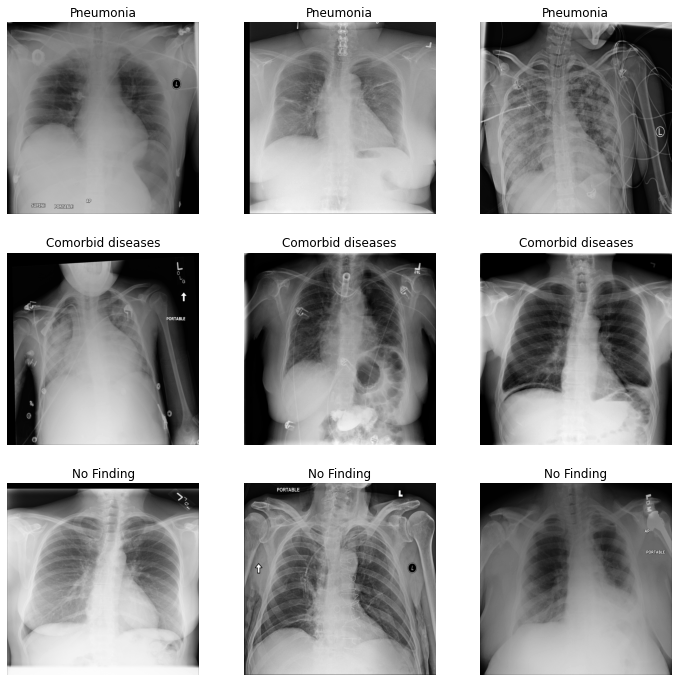

In [35]:
# Glimpse at the x-ray images

image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}
df['ImagePath'] = df['Image Index'].map(image_paths.get)

pneumonia_idx = df[(df["OtherDisease"] == False) & (df.Pneumonia ==1)].index.tolist()
comorbid_idx = df[(df["OtherDisease"] == True) & (df.Pneumonia ==1)].index.tolist()
no_finding_idx = df[df["No Finding"] == True].index.tolist()

random_samples_idx = np.random.choice(pneumonia_idx, 3, replace=False)
random_samples_idx = np.concatenate((random_samples_idx, np.random.choice(comorbid_idx, 3, replace=False)))
random_samples_idx = np.concatenate((random_samples_idx, np.random.choice(no_finding_idx, 3, replace=False)))

fig, m_axs = plt.subplots(3, 3, figsize = (12, 12))
for (idx, ax) in zip(random_samples_idx, m_axs.flatten()):
    image = Image.open(df.ImagePath[idx])
    ax.imshow(image, cmap = 'gray')
    if df.Pneumonia[idx] == 1:  
        if df["OtherDisease"][idx] == True: 
            ax.set_title('Comorbid diseases')
        else:
            ax.set_title('Pneumonia')
    else:
        ax.set_title('No Finding')
    ax.axis('off')

**Insights from looking at the X-ray images:**
- The quality of images differs (brightness, patient position, image position)
- Some images present foreigh bodies (metal parts inside body, medical equipment attached during the examination)
- Images across the same class vary greatly: impossible to label them by a non-expert 

# Pixel-level assessment of imaging data 

In [36]:
## Load data
df3 = pd.read_csv('sample_labels.csv')

In [37]:
# Create a feature with paths to images
image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}
df3['ImagePath'] = df3['Image Index'].map(image_paths.get)

In [38]:
# Create one-hot encodings for each finding label
for label in finding_labels:
    df3[label] = df3["Finding Labels"].map(lambda x: 1. if label in x else 0)

In [39]:
# Create a feature that indicates comorbid diseases 
df3["OtherDisease"] = df3[other_diseases].sum(axis=1) >=1

###  Distribution of pixel intensity values for sample images

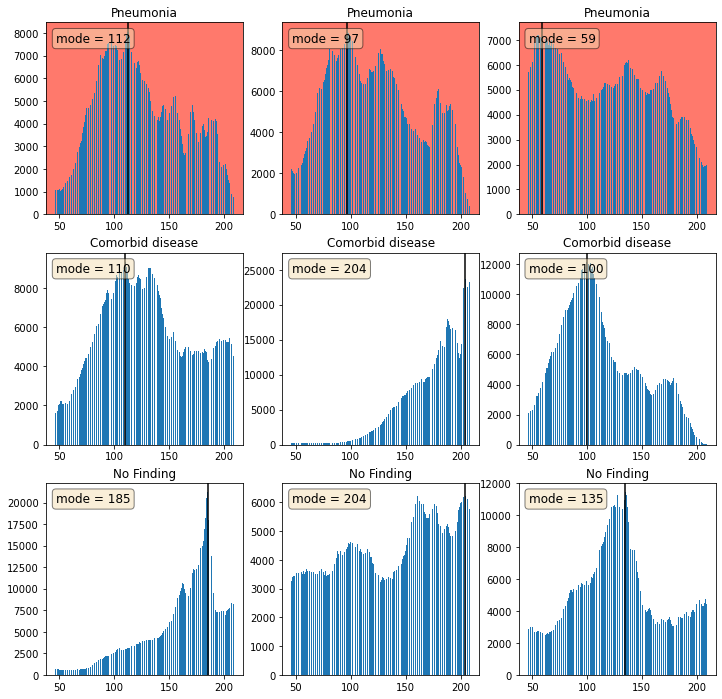

In [40]:
# Create list of indexes corresponding to images with pneumonia, pneumonia+comorbid disease and no finding
pneumonia_idx = df3[(df3["OtherDisease"] == False) & (df3.Pneumonia ==1)].index.tolist()
comorbid_idx = df3[(df3["OtherDisease"] == True) & (df3.Pneumonia ==1)].index.tolist()
no_finding_idx = df3[df3["No Finding"] == True].index.tolist()

# Generate an array with sample images (indexes), 3 per category
random_samples_idx = np.random.choice(pneumonia_idx, 3, replace=False)
random_samples_idx = np.concatenate((random_samples_idx, np.random.choice(comorbid_idx, 3, replace=False)))
random_samples_idx = np.concatenate((random_samples_idx, np.random.choice(no_finding_idx, 3, replace=False)))

# Set thresholds for image background separation
lower_thresh = 45
upper_thresh = 210

fig, m_axs = plt.subplots(3, 3, figsize = (12, 12))
for (idx, ax) in zip(random_samples_idx, m_axs.flatten()):
    
    # Read image and apply mask
    image = io.imread(df3.ImagePath[idx])
    lower_image_bin = (image > lower_thresh)
    upper_image_bin = (image < upper_thresh)
    mask = lower_image_bin * upper_image_bin
    
    # Plot histogram
    ax.hist(image[mask].ravel(), bins=256)
    
    # Plot mode 
    mode = scipy.stats.mode(image[mask].ravel()).mode.item()
    ax.axvline(mode, color='k', linestyle='-')
    
    # Plot mode value
    text6 =  "mode = " + str(mode)
    props6 = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, text6, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props6)
    
    if df3.Pneumonia[idx] == 1: 
        if df3["OtherDisease"][idx] == True: 
            ax.set_title('Comorbid disease')

        else:
            ax.set_title('Pneumonia')
            ax.set_facecolor('xkcd:salmon')
    else:
        ax.set_title('No Finding')

### Distribution of pixel intensity values for images with pneumonia, pneumonia and comorbid diseases and with no finding

In [41]:
# Initialize a dictionary with intensities
intensities_dict = {}
diseases = other_diseases + ["Pneumonia"]
for disease in diseases:
    intensities_dict[disease] = np.zeros((256, 1))
    
intensities_dict["No Finding"] = np.zeros((256, 1))
intensities_dict["Pneumonia+Comorbid"] = np.zeros((256, 1))

In [42]:
# Set thresholds for separation of high-intensity background pixels 
lower_thresh = 25
upper_thresh = 230

In [43]:
for idx in tqdm(df3.index):
    
    # Read image and apply mask to exclude high-intensity background pixels
    image = io.imread(df3.ImagePath[idx])
    lower_image_bin = (image > lower_thresh)
    upper_image_bin = (image < upper_thresh)
    mask = lower_image_bin * upper_image_bin
    
    # Count pixels 
    pixel, count = np.unique(image[mask].ravel(), return_counts=1)
    
    # Save pixel counts in a corresponding list 
    if df3["No Finding"][idx] == 1:
        for idx, pix in enumerate(pixel):
            intensities_dict["No Finding"][pix] += count[idx]
    else:    
        for disease in diseases:                          
            if df3[disease][idx] == 1:
                for idx, pix in enumerate(pixel):
                    intensities_dict[disease][pix] += count[idx]
            
                if (disease == 'Pneumonia') & (df3["OtherDisease"][idx] == 1):
                    for idx, pix in enumerate(pixel):
                        intensities_dict["Pneumonia+Comorbid"][pix] += count[idx]

100%|██████████| 5606/5606 [04:50<00:00, 19.32it/s]


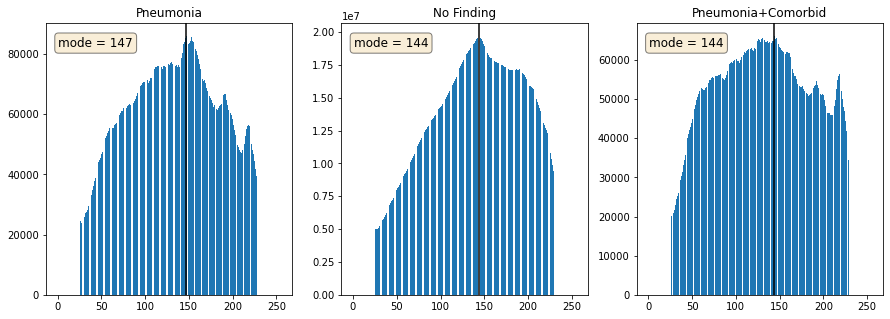

In [44]:
fig, m_axs = plt.subplots(1, 3, figsize = (15, 5))
for ax, data in zip(m_axs.flatten(), list(intensities_dict.keys())[-3:]):
    ax.bar(np.arange(256), intensities_dict[data].ravel())
    ax.set_title(data)
    
    # Plot mode 
    mode = np.argmax(intensities_dict[data])
    ax.axvline(mode, color='k', linestyle='-')
    
    # Plot mode value
    text5 =  "mode = " + str(mode)
    props5 = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, text5, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props5)


### Distribution of pixel intensity values for images with non-pneumonia disease

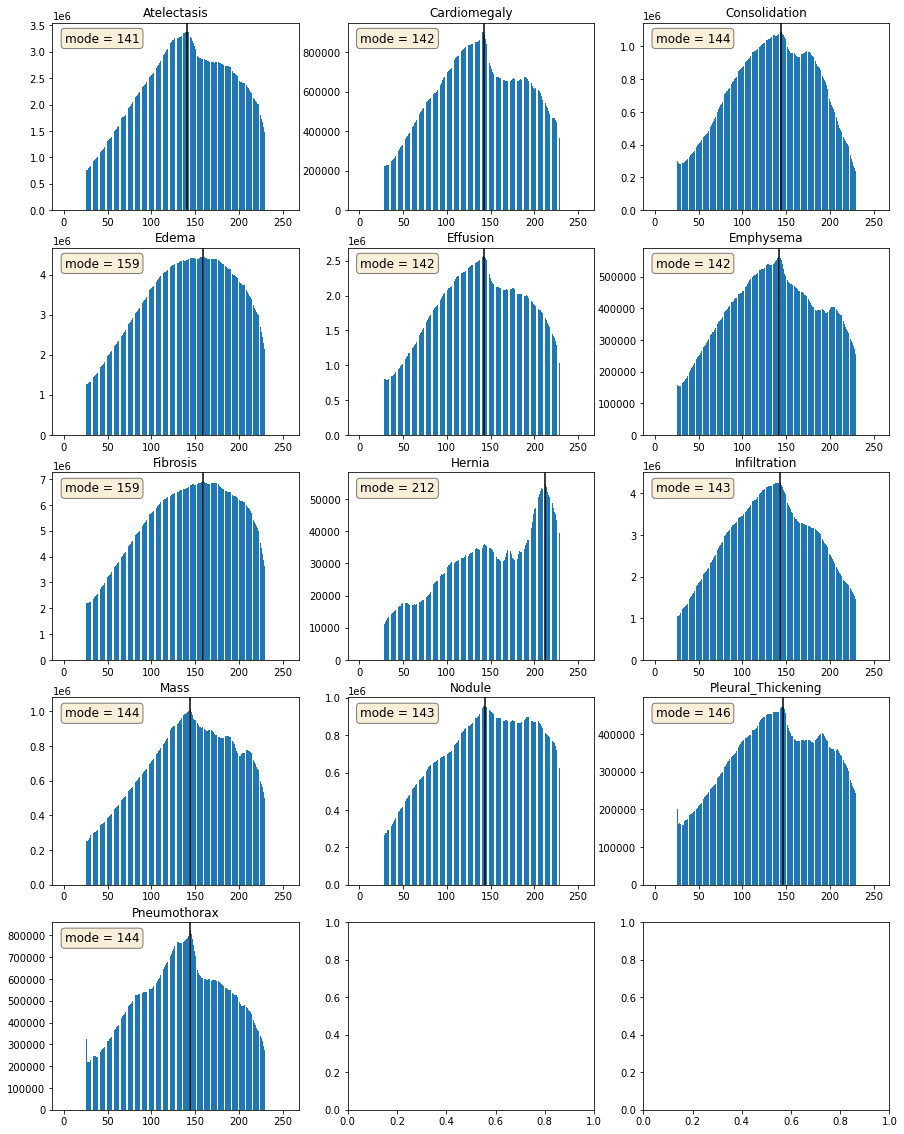

In [45]:
fig, m_axs = plt.subplots(5, 3, figsize = (15, 20))
for ax, data in zip(m_axs.flatten(), list(intensities_dict.keys())[:-3]):
    ax.bar(np.arange(256), intensities_dict[data].ravel())
    ax.set_title(data)
    
    # Plot mode 
    mode = np.argmax(intensities_dict[data])
    ax.axvline(mode, color='k', linestyle='-')
    
    # Plot mode value
    text5 =  "mode = " + str(mode)
    props5 = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, text5, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props5)
